In [2]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [1]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt



The work was distrubuted in this way:
* **Kruskal's + Bellman-Ford algorithm and Prim's algorithm optimisation** - Roman Prokhorov

* **Algorithm comparisment and visualisation** -  Roman Prokhorov

* **Decision tree classifier** - Roman Prokhorov

* **Dataset tunning and fitting it for the classifier** - Taras Kopach

* **Prim's algorithm + Floyd-Warshall  and lab report** - Taras Kopach

* **Report and decision tree classifier analysis** - Taras Kopach


------

**!** For both subtasks of task 1 we analized the time complexity of each algorithm and comparing them to the library-ready algorithms which will show the performance of our team's realisations

# Task 1. Algorithm's analysis

## Generating graph

In [2]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

## Analyze time complexity function

In [3]:
import time
from tqdm import tqdm

def analyze_time_complexity(algorithm_funcs: list[callable], is_directed: bool = False,
                             graph_sizes: list[int] = [5, 10, 20, 50, 100, 200, 500], prob: float = 0.5, number_iterations: int = 1000):
    """ Analyzes the execution time of multiple algorithms for different graph sizes.

    Args:
        algorithm_funcs (list of callable): The list of functions to analyze.
        is_directed (bool): If True, generates directed graphs. Defaults to False.
        number_iterations (int): The number of iterations.
        graph_sizes (list of int): List of graph sizes. Defaults to None.
        prob (float): Probability of edge creation in the random graph. Defaults to 0.5.
    """

    if graph_sizes is None:
        graph_sizes = [5, 10, 20, 50, 100, 200, 500, 1000]

    times = {func.__name__: [] for func in algorithm_funcs}

    for size in tqdm(graph_sizes):
        for algorithm_func in algorithm_funcs:
            total_time = 0

            for _ in range(number_iterations):
                G = gnp_random_connected_graph(size, prob, directed=is_directed)
                start = time.time()

                try:
                    algorithm_func(G)
                except nx.NetworkXUnbounded:
                    pass
                total_time += time.time() - start

            times[algorithm_func.__name__].append(total_time / number_iterations)

    plt.figure(figsize=(8, 5))
    for algorithm_func in algorithm_funcs:
        plt.plot(graph_sizes, times[algorithm_func.__name__], marker='o', linestyle='-', label=algorithm_func.__name__)

    plt.xlabel("Graph Size (Nodes)")
    plt.ylabel("Execution Time (s)")
    plt.title("Time Complexity of Multiple Algorithms")
    plt.legend()
    plt.grid(True)
    plt.show()

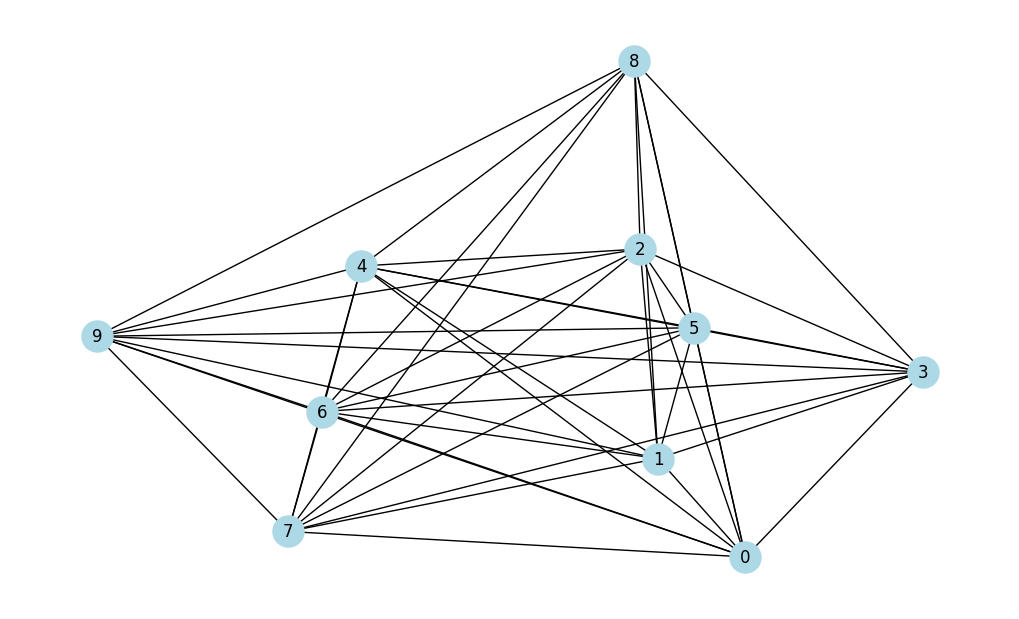

In [7]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1

### Kruskal's algorithm

In [8]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

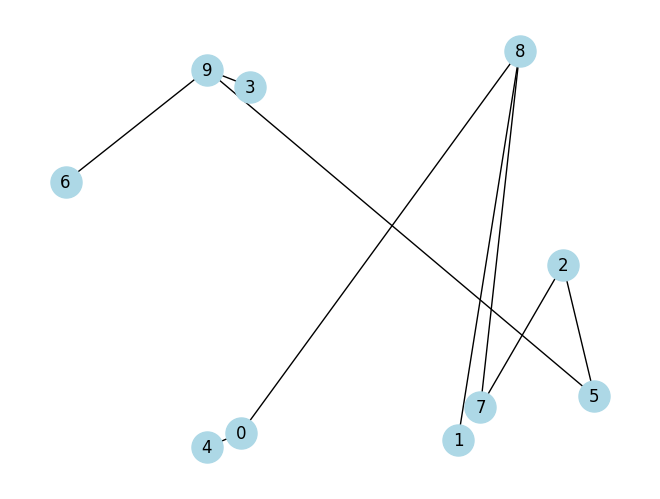

In [9]:
nx.draw(mstk, node_color='lightblue', 
        with_labels=True, 
        node_size=500,
        )

In [11]:
class UnionFind:
    def __init__(self, n: int):
        self.__parent = [v for v in range(n)]
        self.__size = [1] * n

    def find(self, v: int) -> int:
        if self.__parent[v] == v:
            return v

        self.__parent[v] = self.find(self.__parent[v])
        return self.__parent[v]

    def union(self, v1: int, v2: int):
        root1, root2 = self.find(v1), self.find(v2)

        if root1 == root2:
            return
        
        if self.__size[root1] < self.__size[root2]:
            root1, root2 = root2, root1

        self.__parent[root2] = root1
        self.__size[root1] += self.__size[root2]

def kruskals_algorithm(graph: nx.Graph) -> nx.Graph:
    """ Kruskal's algorithm implementation.

    Args:
        graph (nx.Graph): The graph to execute algorithm.

    Returns:
        nx.Graph: The minimum spanning tree
    """

    edges = [(u, v, w['weight']) for u, v, w in graph.edges(data=True)]
    edges.sort(key = lambda x: (x[2]))

    mst = nx.Graph()
    union_find = UnionFind(graph.number_of_nodes())

    for src, dst, weight in edges:
        if union_find.find(src) != union_find.find(dst):
            union_find.union(src, dst)
            mst.add_edge(src, dst, weight = weight)
    
    return mst

In [12]:
mst = kruskals_algorithm(G)

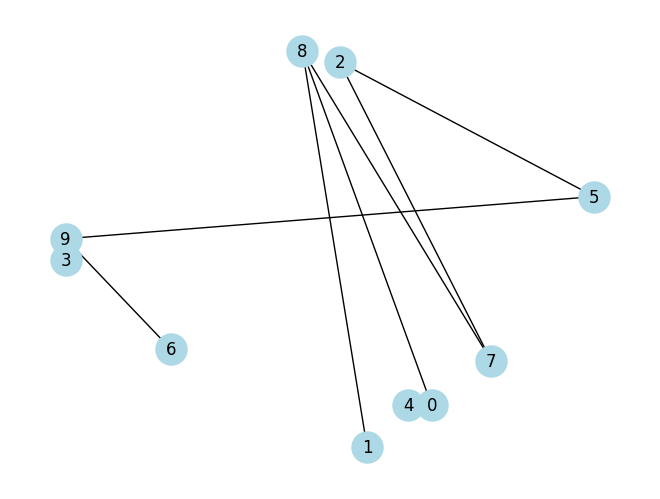

In [13]:
nx.draw(mst, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

### Prim's algorithm

In [15]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

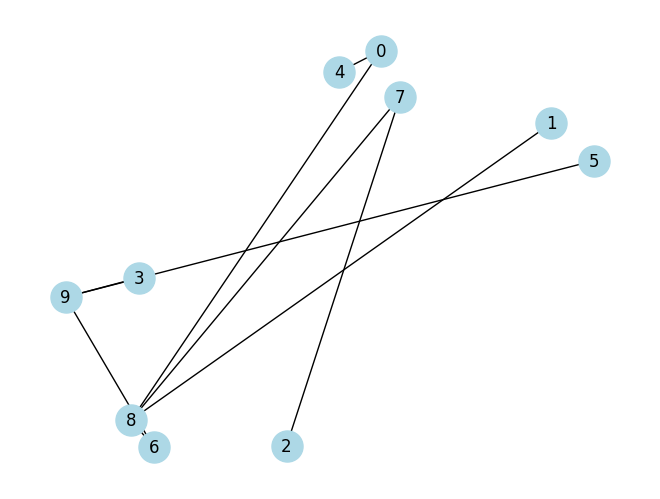

In [16]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [18]:
import heapq

def prim_algorithm(graph: nx.Graph, start: int = 0):
    """haha primt("Hello, world!")"""

    n = graph.number_of_nodes()
    visited = {start}
    span_tree = []

    min_heap = []

    for u, v, data in graph.edges(start, data=True):
        heapq.heappush(min_heap, (data['weight'], u, v))
     
    while len(visited) < n:
        if not min_heap:
            return span_tree

        w, u, v = heapq.heappop(min_heap)

        if v in visited:
            continue
        
        visited.add(v)
        span_tree.append((u, v, w))

        for _, nei, data in  graph.edges(v, data=True):
            if nei not in visited:
                heapq.heappush(min_heap, (data['weight'], v, nei))

    return span_tree


In [19]:
edges= prim_algorithm(G)
mst = nx.Graph() 
mst.add_weighted_edges_from(edges)

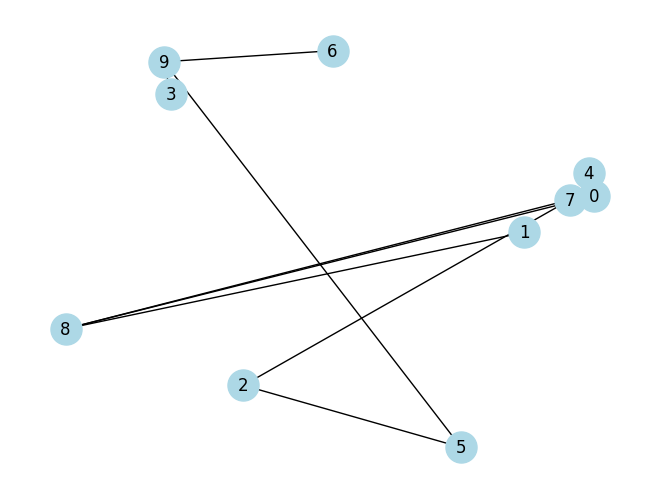

In [20]:
nx.draw(mst, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

100%|██████████| 7/7 [25:08<00:00, 215.47s/it]


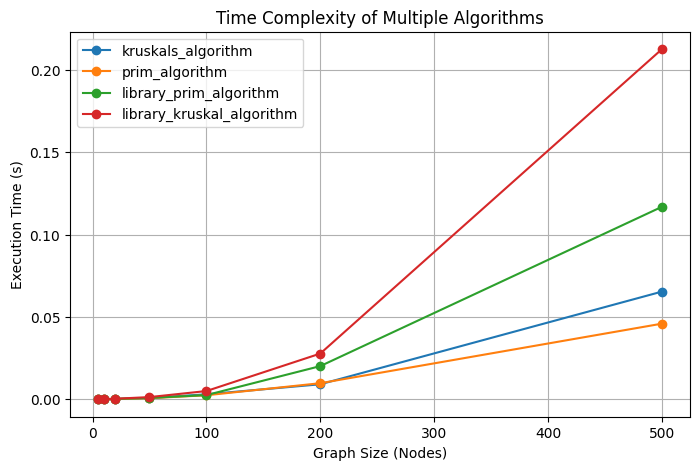

In [238]:
library_kruskal_algorithm = lambda G: nx.minimum_spanning_tree(G, algorithm="kruskal")
library_kruskal_algorithm.__name__ = "library_kruskal_algorithm"

library_prim_algorithm = lambda G: nx.minimum_spanning_tree(G, algorithm='prim')
library_prim_algorithm.__name__ = "library_prim_algorithm"

analyze_time_complexity([kruskals_algorithm, prim_algorithm, library_prim_algorithm, library_kruskal_algorithm], number_iterations = 1000)

### Subtask 1.1

In Subtask 1.1 our team had realised Kruskal's and Prim's algorithms to iterate over NetowkX Graph in order to create a minimum spanning tree



#### Prim's algorithm

The algorithm creates a minimal spanning tree 

**Time Complexity**	

$O((V + E) log V)$

**Space Complexity**	

$O(V + E)$

##### Algorithm work

- Heappush every edge that goes from the starting node to the heapq 

- We repeat this instruction until every node is visited:
    - Heappop the minimal weight edge 
    - **!** We check if the destination node in the edge is not visited, since it will create a cycle and we don't need that
    
    - If everything's ok we add the destination node to the visited set and the edge to the span_tree list

    - We run a cycle adding the edges adjacent to the newly visited node destination, checking the destination nodes of these nodes too.

    - Heappush the edges 

- The visited set should contain all of the nodes of the graph at the moment of the loop breaking, which also signals the end of the algorithm

- We return the edge data for a minimal spanning tree

#### Kruskal's algorithm

The algorithm also creates also a minimal spanning tree 

**Time Complexity**	

$O(E log E)$

**Space Complexity**	

$O(V + E)$

##### Algorithm work

- Create a list of every node of the graph

- Sort those edges by weight

- Create an empty graph, it will be our future minimal spanning tree

- Initialize a UnionFind class with the nodes of a graph

- Iterating over every edge:

    - Perform a union (add edge to our union connectivity component) if both nodes don't have the same parent\representive node (basically if they're not in a union to avoid creating cycles)

    - Add this edge to the MST

- Return the MST

Analysing the performance graph we found that our realisation of the Prim's algorithm works faster than Kruskal's in the 20-70 node region, but performs slower on higer node counts. 


## Subtask 1.2

In [7]:
G = gnp_random_connected_graph(10, 0.5, True, 0)

### Bellman-Ford algorithm

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

In [9]:
def bellman_ford(graph: nx.Graph, source: int = 0):
    n = graph.number_of_nodes()

    distances = {node: float('inf') for node in graph.nodes}
    predecessors = {node: None for node in graph.nodes}
    distances[source] = 0

    for _ in range(n - 1):
        for u, v, data in graph.edges(data=True):
            weight = data['weight']
            if distances[u] != float('inf') and distances[u] + weight < distances[v]:
                distances[v] = distances[u] + weight
                predecessors[v] = u

    for u, v, data in graph.edges(data=True):
        weight = data['weight']
        if distances[u] != float('inf') and distances[u] + weight < distances[v]:
            return -1, -1 
    
    return predecessors, distances

In [ ]:
pred, dist = bellman_ford(G) 

if pred == -1:
    print("Negative cycle detected")
else:
    for k, v in dist.items():
        print(f"Distances to {k}:", v)

### Floyd-Warshall algorithm

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
    print("-"*25)

except:
    print("Negative cycle detected")

In [12]:
from math import inf

def floyd_warshall(graph: nx.Graph):
    n = graph.number_of_nodes()
    matrix = {u: {v: inf for v in range(n)} for u in range(n)}
    pred = {u: {} for u in range(n)}
    
    for u in range(n):
        matrix[u][u] = 0

    for u, v, data in graph.edges(data=True):
        matrix[u][v] = data["weight"]
        pred[u][v] = u
    
    for i in range(n):
        for u in range(n):
            if matrix[u][i] == inf:
                continue

            for v in range(n):
                if matrix[u][i] + matrix[i][v] < matrix[u][v]:
                    matrix[u][v] = matrix[u][i] + matrix[i][v]
                    pred[u][v] = pred[u][i]  

    return pred, matrix

In [ ]:
pred, dist = floyd_warshall(G) 
for k, v in dist.items():
    print(f"Distances with {k} source:", dict(v))

print("-"*25)

100%|██████████| 7/7 [07:40<00:00, 65.73s/it] 


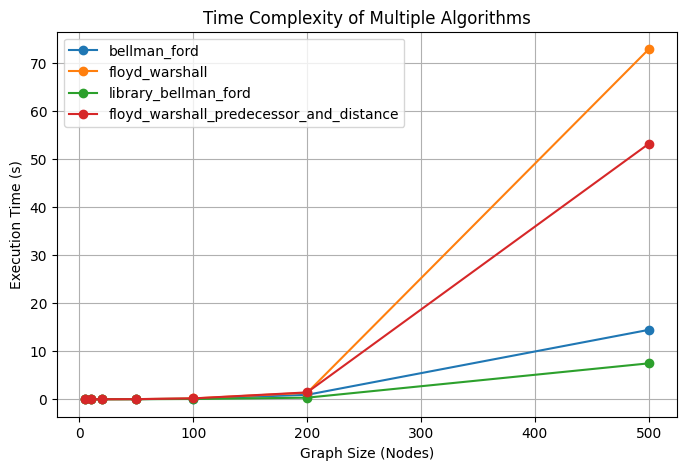

In [15]:
library_bellman_ford = lambda G:  bellman_ford_predecessor_and_distance(G, 0)

library_bellman_ford.__name__ = "library_bellman_ford"

analyze_time_complexity([bellman_ford, floyd_warshall, library_bellman_ford, floyd_warshall_predecessor_and_distance], \
                         True, number_iterations = 3)

### Subtask 1.2


#### Bellman-Ford algorithm

Finds the shorest simple path between any two nodes.

**Time Complexity**
$O(V * E)$

**Space Complexity**
$O(V)$

##### Algorithm work

- Get the nodes and create distances and predecessors dict matricies

- Iterating **n - 1** times we compare the distances from source to each node and comparing with the set values in the distances matrix

    - If we find a shorter distance between the nodes, we set this value to the dict and the predecessor node to the predecessors matrix

    - Check if there is no negative cycles within the graph, return -1, -1 if there are 

- Return the predecessors sand distances matrices



#### Floyd-Warshall algorithm

Finds the shorest simple path between any two nodes.

**Time Complexity**
$O(V^3)$

**Space Complexity**
$O(V^2)$

##### Algorithm work

- Create distances and predecessors matrices 

- Set the distance for each node in the diagonal (n -> n) equal to 0

- Fill the matrices with data from edges of the graph

- Iterating through a possible intermediate node and through source\desination nodes we check the distance with through the intermediate node is shorter than the initial distance between two nodes. If there is this distance we change the distances and predecessors matrices

- Return the predecessors sand distances matrices



While realising both algorithms we noticed that our floyd-warshall's algorithm realisation didn't have a proper negative cycle detection, making our bellman-ford's algorithm realisation work better with finding the shortest path and do it faster overall. Analysing the performance graph, we can tell the a huge time difference is present when there are 200+ nodes in a graph.


---

## Task 2. Decision Tree Classifier 

In [17]:
# scikit-learn package
from sklearn.tree import export_graphviz
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [18]:
class Node:
    def __init__(self, predicted_class: str, number_samples_per_class: npt.NDArray, number_samples: int, gini: float):
        """ Node object.

        Args:
            predicted_class (str): The major class.
            number_samples_per_class (npt.NDArray): The number of samples of each class.
            number_samples (int): The number of sampels.
            gini (float): The gini number.
        """

        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None
        self.predicted_class = predicted_class
        self.gini = gini
        self.number_samples = number_samples
        self.number_samples_per_class = number_samples_per_class
    
    # source: https://github.com/joachimvalente/decision-tree-cart.git
    def debug(self, feature_names, class_names, show_details):
        """Print an ASCII visualization of the tree."""
        lines, _, _, _ = self._debug_aux(
            feature_names, class_names, show_details, root=True
        )
        for line in lines:
            print(line)

    def _debug_aux(self, feature_names, class_names, show_details, root=False):
        is_leaf = not self.right
        if is_leaf:
            lines = [class_names[self.predicted_class]]
        else:
            lines = [
                "{} < {:.2f}".format(feature_names[self.feature_index], self.threshold)
            ]
        if show_details:
            lines += [
                "gini = {:.3f}".format(self.gini),
                "samples = {}".format(self.number_samples),
                str(self.number_samples_per_class),
            ]
        width = max(len(line) for line in lines)
        height = len(lines)
        if is_leaf:
            lines = ["║ {:^{width}} ║".format(line, width=width) for line in lines]
            lines.insert(0, "╔" + "═" * (width + 2) + "╗")
            lines.append("╚" + "═" * (width + 2) + "╝")
        else:
            lines = ["│ {:^{width}} │".format(line, width=width) for line in lines]
            lines.insert(0, "┌" + "─" * (width + 2) + "┐")
            lines.append("└" + "─" * (width + 2) + "┘")
            lines[-2] = "┤" + lines[-2][1:-1] + "├"
        width += 4  # for padding

        if is_leaf:
            middle = width // 2
            lines[0] = lines[0][:middle] + "╧" + lines[0][middle + 1 :]
            return lines, width, height, middle

        # If not a leaf, must have two children.
        left, n, p, x = self.left._debug_aux(feature_names, class_names, show_details)
        right, m, q, y = self.right._debug_aux(feature_names, class_names, show_details)
        top_lines = [n * " " + line + m * " " for line in lines[:-2]]
        # fmt: off
        middle_line = x * " " + "┌" + (n - x - 1) * "─" + lines[-2] + y * "─" + "┐" + (m - y - 1) * " "
        bottom_line = x * " " + "│" + (n - x - 1) * " " + lines[-1] + y * " " + "│" + (m - y - 1) * " "
        # fmt: on
        if p < q:
            left += [n * " "] * (q - p)
        elif q < p:
            right += [m * " "] * (p - q)
        zipped_lines = zip(left, right)
        lines = (
            top_lines
            + [middle_line, bottom_line]
            + [a + width * " " + b for a, b in zipped_lines]
        )
        middle = n + width // 2
        if not root:
            lines[0] = lines[0][:middle] + "┴" + lines[0][middle + 1 :]
        return lines, n + m + width, max(p, q) + 2 + len(top_lines), middle

In [24]:
class DecisionTreeClassifier_:
    def __init__(self, max_depth: int = 2):
        """ Initialization method,

        Args:
            max_depth (int, optional): The maximum depth of  the tree. Defaults to 2.
        """
        self.max_depth = max_depth

    def fit(self, X: npt.NDArray, y: npt.NDArray):
        """ Creates tree of decisions for given samples.

        Args:
            X (npt.NDArray): Features of samples.
            y (npt.NDArray): Classes of samples.
        """

        self.number_of_classes = len(set(y))
        self.number_of_features = X.shape[1]
        self.tree = self.grow_tree(X, y)

    def predict(self, X_test: npt.NDArray) -> npt.NDArray:
        """
        Traverse the tree while there is a child
        and return the predicted class for it 
        """
    
        return [self._predict(inputs) for inputs in X_test]

    def debug(self, feature_names: list[str], class_names: list[str], show_details = True):
        """Print ASCII visualization of decision tree."""

        self.tree.debug(feature_names, class_names, show_details)

    def get_gini(self, class_counts: list[int], num_samples: int) -> float:
        """ Calculates gini.

        Args:
            class_counts (list[int]): The number of each class.
            num_samples (int): The number of samples.

        Returns:
            float: The gini number.
        """

        return 1.0 - sum((count / num_samples) ** 2 for count in class_counts)

    def best_split(self, X: npt.NDArray, y: npt.NDArray) -> tuple[int, float]:
        """ Finds the best index of split for a node.

        Args:
            X (npt.NDArray): Features of samples.
            y (npt.NDArray): Classes of samples.

        Returns:
            best_idx: The index of the split.
            best_thr: The best threshold.
        """
        
        num_samples = y.size

        if num_samples <= 1:
            return None, None

        curr_number_per_class = [np.sum(y == c) for c in range(self.number_of_classes)]

        best_gini = 1.0 - self.get_gini(curr_number_per_class, num_samples)
        best_idx, best_thr = None, None

        for split_idx in range(self.number_of_features):
            thresholds, classes = zip(*sorted(zip(X[:, split_idx], y)))

            number_in_left = [0] * self.number_of_classes
            number_in_right = curr_number_per_class.copy()

            for i in range(1, num_samples):
                current_class = classes[i - 1]

                number_in_left[current_class] += 1
                number_in_right[current_class] -= 1

                gini_left = self.get_gini(number_in_left, i)
                gini_right = self.get_gini(number_in_right, num_samples - i)

                gini = (i * gini_left + (num_samples - i) * gini_right) / num_samples

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = split_idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2 

        return best_idx, best_thr

    def grow_tree(self, X: npt.NDArray, y: npt.NDArray, depth: int = 0) -> Node:
        """ Grows tree adding recursively nodes.

        Args:
            X (npt.NDArray): Features of samples.
            y (npt.NDArray): Classes of samples.
            depth (int, optional): The current depth of the tree. Defaults to 0.

        Returns:
            Node: The current node.
        """

        number_samples_per_class = [np.sum(y == i) for i in range(self.number_of_classes)]
        predicted_class = np.argmax(number_samples_per_class)

        node = Node(
            gini = self.get_gini(number_samples_per_class, y.size),
            number_samples = y.size,
            number_samples_per_class = number_samples_per_class,
            predicted_class = predicted_class,
        )

        if depth >= self.max_depth:
            return node

        split_idx, threshold = self.best_split(X, y)

        if split_idx is None:
            return node

        indices_left = X[:, split_idx] < threshold

        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[~indices_left], y[~indices_left]

        node.feature_index = split_idx
        node.threshold = threshold
        node.left = self.grow_tree(X_left, y_left, depth + 1)
        node.right = self.grow_tree(X_right, y_right, depth + 1)

        return node

    def _predict(self, inputs: npt.NDArray) -> int:
        """ Predicts class for a sample.

        Args:
            inputs (npt.NDArray): Given sample.

        Returns:
            int: The index of class.
        """

        node = self.tree

        while node.left:

            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right

        return int(node.predicted_class)


In [20]:
def evaluate(X_test: list[list], y_test: list, tree: DecisionTreeClassifier_) -> float:
    """ Returns accuracy of the model
    (ratio of right guesses to the number of samples)

    Args:
        X (npt.NDArray): Features of samples.
        y (npt.NDArray): Classes of samples.
    
    Returns:
        float: The accuracy.
    """

    predictions = tree.predict(X_test)

    accuracy = sum(predictions == y_test) / len(y_test)

    return accuracy

In [21]:
data = pd.read_csv("attack_data.csv")

data_clean = data.dropna(subset=["launched", "destroyed", "not_reach_goal", "model"])

y = data_clean["model"]
features = ["launched", "destroyed", "not_reach_goal"]
models = sorted(set(data_clean["model"])) 

model_to_index = {model: idx for idx, model in enumerate(models)}
index_to_model = {idx: model for model, idx in model_to_index.items()}

y_encoded = np.array([model_to_index[model] for model in y])

X = data_clean[features]
X_test = np.array(X)

[1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2]
[1 2 2 2 1 1 2 1 2 2 2 2 1 2 1 2 2 2 2 1 2 1 2 2 1 2 2 2 2 2 1 1 1 1 2 1 1
 2 2 1 2]
0.9512195121951219
0.9512195121951219
                                                                                                                                                                                                                         ┌───────────────────────────────────────────┐                                                                                                                                                                                                                          
                                                                                                                                                                                                                         │             destroyed < 1.50              │          

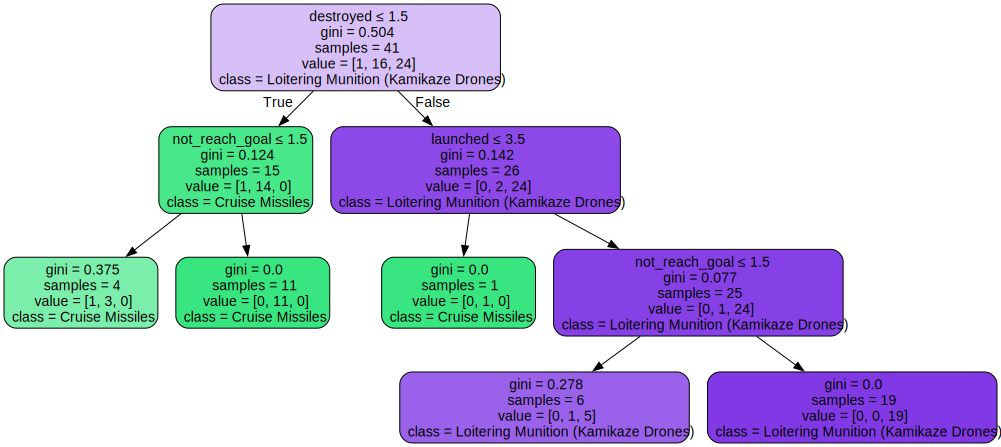

In [25]:
clf = DecisionTreeClassifier_(max_depth = 3)
clf_library = DecisionTreeClassifier(max_depth = 3)

clf.fit(X_test, y_encoded)
predictions = clf.predict(X_test)

clf_library.fit(X_test, y_encoded)
predictions_library = clf_library.predict(X_test)

print(predictions)
print(predictions_library)

print(evaluate(X_test, y_encoded, clf))
print(evaluate(X_test, y_encoded, clf_library))

# clf.debug(features, models)

dot_data = export_graphviz(clf_library, out_file=None,
                    class_names=models,
                    feature_names=features,
                     filled=True, rounded=True,  
                     special_characters=True)
  
graph = graphviz.Source(dot_data)  
graph

## Task 2 Report

For this task we had to create a decision tree classifier based on some data


#### Dataset

The data set used for this classifier is about daily russian (as of 4:00 AM January 23, 2025) attacks on Ukraine. For classification and filtering we picked these criteria:

+ Model of weapon (Drone, Missile, Bomb, etc)

+ Amount of weapons launched

+ Amount of destroyed targets

+ Targets, that didn't reach their goal

The dataset was slightly tuned, filling null values with "*Unknown*" or dropping them, since some information could be classified or not accurate.


#### Development

The decision tree grows by recursively splitting data at each node. The best_split method identifies the feature and threshold that minimize impurity (Gini index), while grow_tree constructs the tree step by step:
- Create a Node – Assign the most common class and store relevant information at the current node.
- Determine the Best Split – Identify the feature and threshold that best separate the classes by calculating the Gini index.
- Divide the Data – Split the samples into left and right subsets based on the chosen threshold.
- Create Left and Right Children – Generate child nodes and assign the corresponding subsets.
- Recursively Expand Subtrees – Repeat the process for both child nodes.

It is developed to grow until it reaches maximum height (It's set to 3)




##### Prediction

The prediction method of the decision tree takes a sample and traverses the decision tree to determine its class. Starting from the root, it moves left if the feature value satisfies the threshold and right otherwise. Once it reaches a leaf node, it returns the predicted class index.

##### Visualisation

To make the visualisator work with our dataset, we had to use an open source debugger and visulisator

Credit: 
https://github.com/joachimvalente/decision-tree-cart.git

#### Gini

Our decision tree classifier successfuly managed to get pure nodes with gini impurity of 0, getting the samples of the models with the decision data we would need.

#### Summary

The classification could show which types of weapons (models) were not destroyed, comparing to their classification criteria
 Example: One node from the tree shows that there are less cases of UAV's not reaching their targets, comparing to cruise missiles, which could be explained by the amount of launched units. 